In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')
methods = ['VG', 'COW', 'LNAM']

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [3]:
with open('/srv/scratch/z5297792/Sample/eddy_sub_data.pkl', 'rb') as file:
    eddy_sub_data = pickle.load(file)
the_frontier_eddies = list(eddy_sub_data.keys())

In [4]:
depth_data_dic = {}
for eddy in the_frontier_eddies:
    depth_data_dic[eddy] = {}
    for method in methods:
        
        depth_dfs = []
        for t in range(30):
            for col in ['x', 'y', 'TD']:
                depth_data = eddy_sub_data[eddy][f'T{t}'][method]['depth_data'][['Depth', col]]
                depth_data.columns = ['Depth', f'{col}{t}']
                depth_dfs.append(depth_data.set_index('Depth'))
        depth_df = pd.concat(depth_dfs, axis=1).sort_index(ascending=False)
        depth_data_dic[eddy][method] = depth_df

In [28]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

def depth_shift_finder(depth_df):

    best_shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
    for t in range(4):
        if t in [0,1]:
            # Sample data 
            x_t1 = depth_df['x'+str(t)]/1000  # x-coordinates at t1
            y_t1 = depth_df['y'+str(t)]/1000   # y-coordinates at t1
            x_t2 = depth_df['x'+str(t+1)]/1000  # x-coordinates at t2
            y_t2 = depth_df['y'+str(t+1)]/1000   # y-coordinates at t2
        
            # Objective function
            def R(params):
                a, b, theta = params
                cos_theta = np.cos(theta)
                sin_theta = np.sin(theta)
                term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
                term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
                return np.sum(term1 + term2)
            
            # Initial guess for a, b, theta
            initial_guess = [0, 0, 0]
            
            # Optimize
            result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
            a_opt, b_opt, theta_opt = result.x
            error = R((a_opt, b_opt, theta_opt))
            theta_opt = np.rad2deg(theta_opt)
            
            # print(f"Optimal a: {a_opt}, b: {b_opt}, theta: {theta_opt}, rmse: {rmse}")
            best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}
        else:
            best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'rmse': 0}
        
    best_shift_3D_df.set_index('Day', inplace=True)

    best_shift_3D_df = best_shift_3D_df.iloc[::-1].cumsum().iloc[::-1]
    
    return best_shift_3D_df

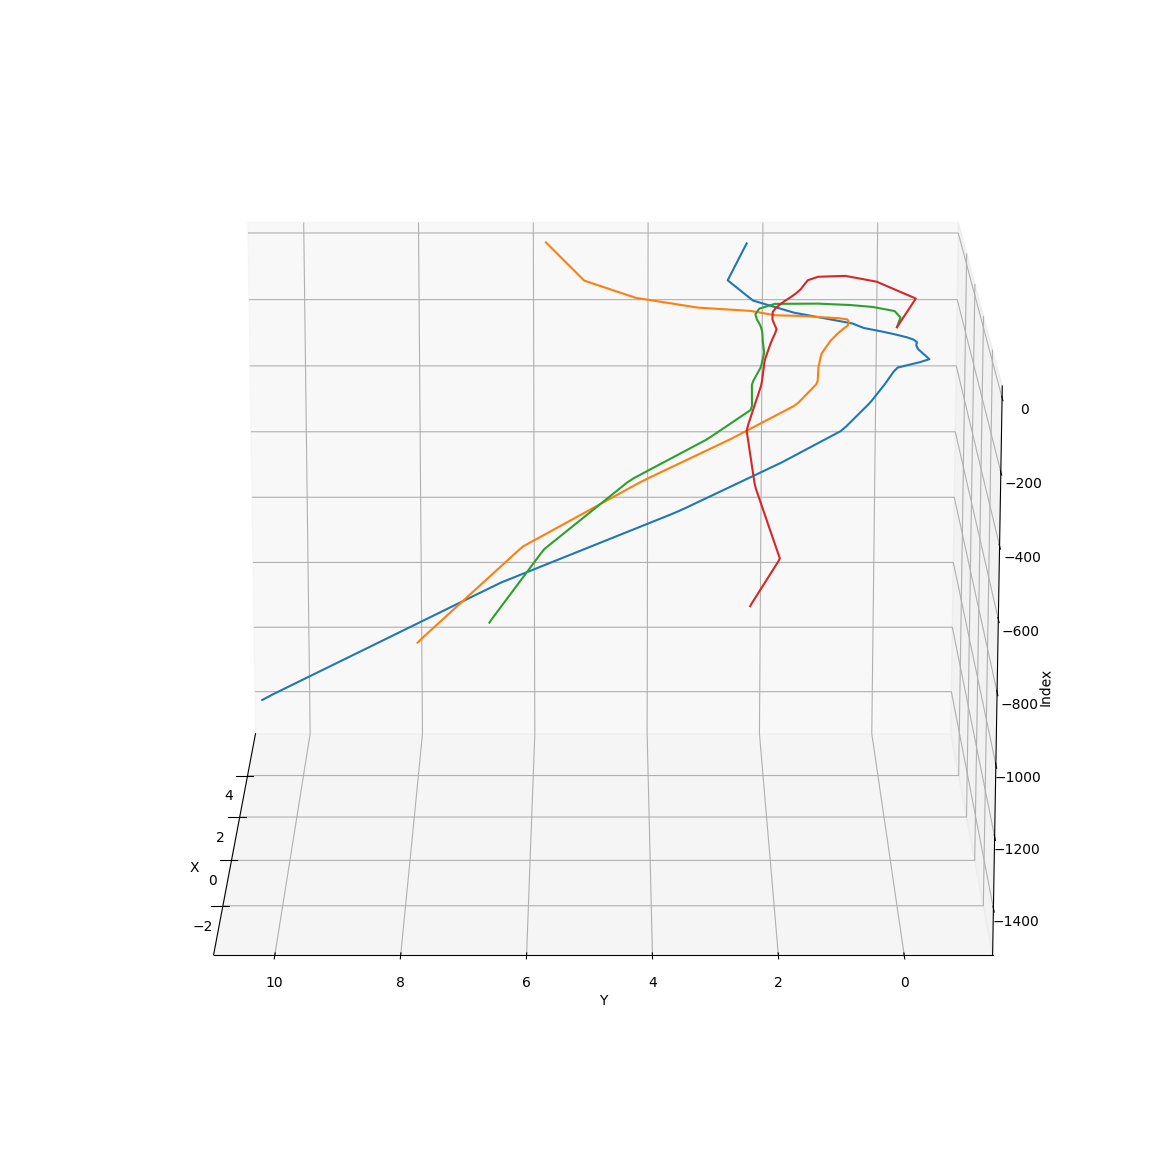

In [29]:
# Find best shifts

eddy = the_frontier_eddies[0]
method = 'VG'

best_depth_shift_dic = {}
best_depth_shift_dic[eddy] = {}
depth_df = depth_data_dic[eddy][method]
best_depth_shift_df = depth_shift_finder(depth_df)
best_depth_shift_dic[eddy][method] = best_depth_shift_df

import copy
applied_shift = copy.deepcopy(depth_data_dic)
for t in range(4):
    theta = best_depth_shift_dic[eddy][method].loc[t]['theta']
    i = best_depth_shift_dic[eddy][method].loc[t]['i']
    j = best_depth_shift_dic[eddy][method].loc[t]['j']
    x = applied_shift[eddy][method]['x'+str(t)] / 1000
    y = applied_shift[eddy][method]['y'+str(t)] / 1000
    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j
    applied_shift[eddy][method]['x'+str(t)] = x_shifted
    applied_shift[eddy][method]['y'+str(t)] = y_shifted


df = applied_shift[eddy][method]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for t in range(4):
    ax.plot(df['x'+str(t)], df['y'+str(t)], df.index)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Index')
ax.view_init(15, 180)

plt.show()



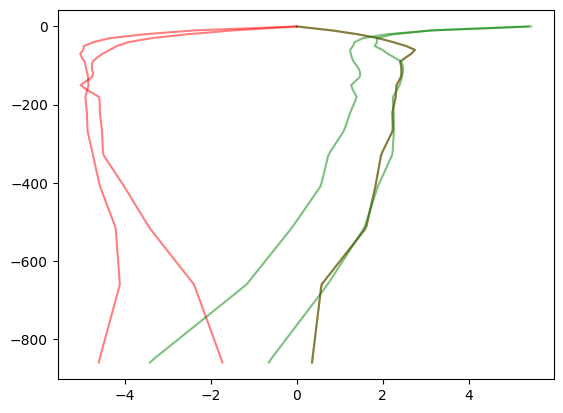

In [47]:

eddy = the_frontier_eddies[0]
method = 'VG'

df = depth_data_dic[eddy][method]


y1, y2, y3 = df['y0']/1000, df['y1']/1000, df['y2']/1000

t_end = 3

best_shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):

    # Sample data 
    x_t1 = df['x'+str(t)]/1000  # x-coordinates at t1
    y_t1 = df['y'+str(t)]/1000   # y-coordinates at t1
    x_t2 = df['x'+str(t+1)]/1000  # x-coordinates at t2
    y_t2 = df['y'+str(t+1)]/1000   # y-coordinates at t2

    # Objective function
    def R(params):
        a, b, theta = params
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
        term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
        return np.sum(term1 + term2)
    
    # Initial guess for a, b, theta
    initial_guess = [0, 0, 0]
    
    # Optimize
    result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
    a_opt, b_opt, theta_opt = result.x
    error = R((a_opt, b_opt, theta_opt))
    theta_opt = np.rad2deg(theta_opt)
    
    # print(f"Optimal a: {a_opt}, b: {b_opt}, theta: {theta_opt}, rmse: {rmse}")
    best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

for t in range(t_end):
    plt.plot(df['x'+str(t)]/1000, df.index, 'r', alpha=1 if t==t_end else .5)

df_shifted = df.copy()
for t in range(t_end):
    theta = best_depth_shift_dic[eddy][method].loc[t]['theta']
    i = best_depth_shift_dic[eddy][method].loc[t]['i']
    j = best_depth_shift_dic[eddy][method].loc[t]['j']
    x = df['x'+str(t)] / 1000
    y = df['y'+str(t)] / 1000
    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j
    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

    plt.plot(x_shifted, df_shifted.index, 'g', alpha=1 if t==t_end else .5)






In [57]:
df

,x0,x1,x2,y,z
0,0,1,2,0,-5
1,0,1,2,0,-4
2,0,1,2,0,-3
3,0,1,2,0,-2
4,0,1,2,0,-1
5,0,1,2,0,0


,theta,i,j,Error
Day,,,,
0,2.477266e-08,8.936179,-4.470164e-08,1.194471
1,0.000000e+00,7.939214,-3.969554e-08,1.175908
2,0.000000e+00,6.937448,-3.506144e-08,0.975609
3,0.000000e+00,5.982454,-3.042282e-08,0.795677
4,0.000000e+00,4.901078,-2.517033e-08,0.730702
5,0.000000e+00,3.980550,-2.048620e-08,0.592918
6,0.000000e+00,2.904576,-1.501108e-08,0.505686
7,0.000000e+00,1.905491,-9.696134e-09,0.260002
8,0.000000e+00,0.865443,-4.403823e-09,0.063521


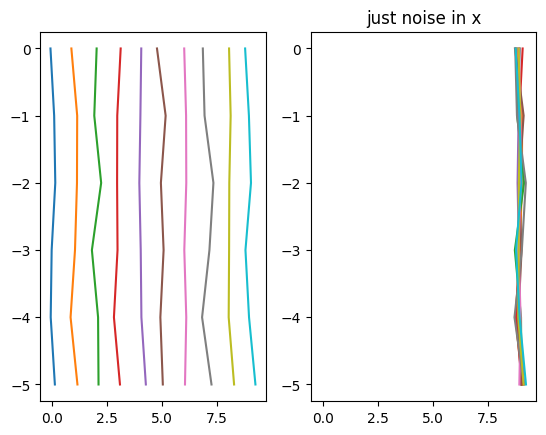

In [135]:
z = np.arange(-5,1)

t_end = 10

noise = .2

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] #+ np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):
    if t == t_end-1:
        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'Error': 0}
    else:
        # Sample data 
        x_t1 = df['x'+str(t)] # x-coordinates at t1
        y_t1 = df['y'+str(t)]   # y-coordinates at t1
        x_t2 = df['x'+str(t+1)] # x-coordinates at t2
        y_t2 = df['y'+str(t+1)]   # y-coordinates at t2
    
        # Objective function
        def R(params):
            a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
            term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
            return np.sum(term1 + term2)
        
        # Initial guess for a, b, theta
        initial_guess = [0, 0, 0]
        
        # Optimize
        result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
        a_opt, b_opt, theta_opt = result.x
        error = R((a_opt, b_opt, theta_opt))
        theta_opt = np.rad2deg(theta_opt)

        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')
best_shift_df = best_shift_df.iloc[::-1].cumsum().iloc[::-1]

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

axs[1].set_title('just noise in x')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

best_shift_df

,theta,i,j,Error
Day,,,,
0,147.198794,11.707024,-8.760123,2.134021
1,132.958232,10.777061,-8.770097,2.055727
2,92.133826,9.405376,-8.140162,1.780533
3,92.133826,8.389613,-8.130056,1.617353
4,92.133826,7.320868,-8.070356,1.323935
5,62.413042,5.866824,-5.991641,1.158541
6,18.329360,3.413379,-2.502013,0.890891
7,18.329360,2.409726,-2.486567,0.703487
8,18.329360,1.476196,-2.577405,0.354732


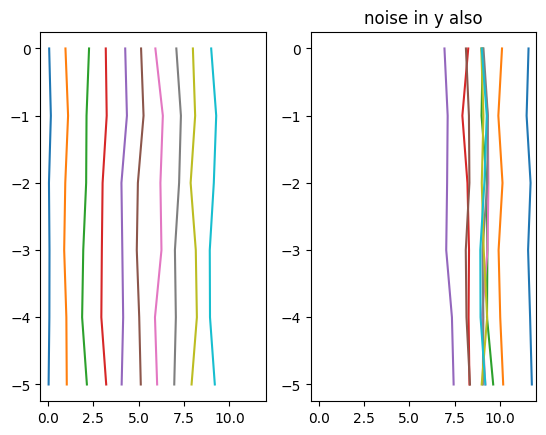

In [144]:
z = np.arange(-5,1)

t_end = 10

noise = .2

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] + np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):
    if t == t_end-1:
        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'Error': 0}
    else:
        # Sample data 
        x_t1 = df['x'+str(t)] # x-coordinates at t1
        y_t1 = df['y'+str(t)]   # y-coordinates at t1
        x_t2 = df['x'+str(t+1)] # x-coordinates at t2
        y_t2 = df['y'+str(t+1)]   # y-coordinates at t2
    
        # Objective function
        def R(params):
            a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
            term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
            return np.sum(term1 + term2)
        
        # Initial guess for a, b, theta
        initial_guess = [0, 0, 0]
        
        # Optimize
        result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
        a_opt, b_opt, theta_opt = result.x
        error = R((a_opt, b_opt, theta_opt))
        theta_opt = np.rad2deg(theta_opt)

        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')
best_shift_df = best_shift_df.iloc[::-1].cumsum().iloc[::-1]

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

axs[1].set_title('noise in y also')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

best_shift_df

,theta,i,j,Error
Day,,,,
0,11.452646,4.947459,4.766554,2.142785
1,4.404855,4.304613,3.828677,5.283796
2,0.000000,3.071644,2.648463,4.421244
3,32.134087,4.062357,0.772972,5.813806
4,0.000000,0.536824,0.952940,5.295182
5,0.000000,0.000000,0.000000,0.000000
6,5.716611,-0.334098,-2.005931,3.688397
7,34.826766,3.385127,-5.089673,3.040749
8,35.342019,3.295251,-6.187493,3.485021


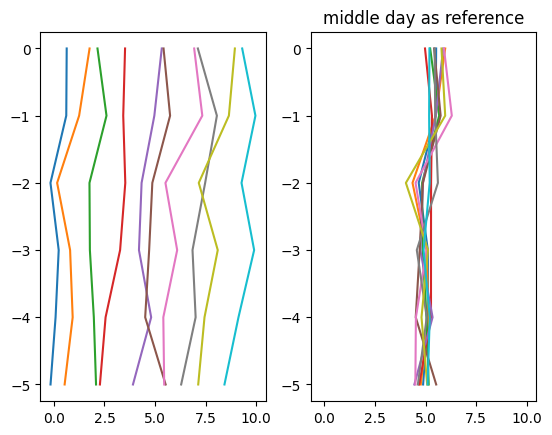

In [145]:
z = np.arange(-5,1)

t_end = 10

noise = .8

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] + t + np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):

    # Sample data 
    x_t1 = df['x'+str(t)] # x-coordinates at t1
    y_t1 = df['y'+str(t)]   # y-coordinates at t1
    x_t2 = df['x'+str(t_end//2)] # x-coordinates at t2
    y_t2 = df['y'+str(t_end//2)]   # y-coordinates at t2

    # Objective function
    def R(params):
        a, b, theta = params
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
        term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
        return np.sum(term1 + term2)
    
    # Initial guess for a, b, theta
    initial_guess = [0, 0, 0]
    
    # Optimize
    result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
    a_opt, b_opt, theta_opt = result.x
    error = R((a_opt, b_opt, theta_opt))
    theta_opt = np.rad2deg(theta_opt)

    best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

axs[1].set_title('middle day as reference')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

best_shift_df


In [83]:
np.random.uniform(-0.2, 0.2)

0.10754177697445022